In [7]:
class_names = dict((
(0, "Water"),
(1, "Snow/Ice"),
(2, "Open Space Developed"),
(3, "Low Intensity Developed"),
(4, "Medium Intensity Developed"),
(5, "High Intensity Developed"),
(6, "Barren Land"),
(7, "Deciduous Forest"),
(8, "Evergreen Forest"),
(9, "Mixed Forest"),
#(51, "Dwarf Scrub/Shrub - ALASKA"),
(10, "Scrub/Shrub"),
(11, "Grassland / Herbaceous"),
#(72, "Sedge / Herbaceous - ALASKA"),
#(73, "Lichen / Herbaceous - ALASKA"),
#(74, "Moss - ALASKA"),
(12, "Pasture/Hay"),
(13, "Cultivated Land"),
(14, "Woody Wetland"),
(15, "Emergent Herbaceous Wetlands"),
))


In [8]:
import rasterio
import numpy as np
import keras
from keras.optimizers import SGD, Adam
import os
import resnet as rs
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import classifier_utilities as cu

In [9]:
os.environ["CUDA_VISIBLE_DEVICES"]="3";

In [10]:
label_dataset = rasterio.open('/deep_data/NLCD/NLCD_2016_Land_Cover_L48_20190424.img')

l8_image_paths = [
    '/deep_data/processed_landsat/LC08_CU_027012_20170907_20181121_C01_V01_SR_combined.tif',
    '/deep_data/processed_landsat/LC08_CU_028011_20170907_20181130_C01_V01_SR_combined.tif',  
    '/deep_data/processed_landsat/LC08_CU_028012_20171002_20171019_C01_V01_SR_combined.tif',
    '/deep_data/processed_landsat/LC08_CU_028012_20171103_20190429_C01_V01_SR_combined.tif',
    '/deep_data/processed_landsat/LC08_CU_029011_20171018_20190429_C01_V01_SR_combined.tif'
]

s1_image_paths = [
    '/deep_data/sentinel_sar/LC08_CU_027012_20170907_20181121_C01_V01_SR_combined/aligned-LC08_CU_027012_20170907_20181121_C01_V01_SR_combined_SAR.tif',
    '/deep_data/sentinel_sar/LC08_CU_028011_20170907_20181130_C01_V01_SR_combined/aligned-LC08_CU_028011_20170907_20181130_C01_V01_SR_combined_SAR.tif',
    '/deep_data/sentinel_sar/LC08_CU_028012_20171002_20171019_C01_V01_SR_combined/aligned-LC08_CU_028012_20171002_20171019_C01_V01_SR_combined_SAR.tif',
    '/deep_data/sentinel_sar/LC08_CU_028012_20171103_20190429_C01_V01_SR_combined/aligned-LC08_CU_028012_20171103_20190429_C01_V01_SR_combined_SAR.tif',
    '/deep_data/sentinel_sar/LC08_CU_029011_20171018_20190429_C01_V01_SR_combined/aligned-LC08_CU_029011_20171018_20190429_C01_V01_SR_combined_SAR.tif',
]

dem_image_paths = [
    '/deep_data/sentinel_sar/LC08_CU_027012_20170907_20181121_C01_V01_SR_combined_dem/aligned-wms_DEM_EPSG4326_-79.69001_33.95762_-77.7672_35.51886__4500X4631_ShowLogo_False_tiff_depth=32f.tiff',
    '/deep_data/sentinel_sar/LC08_CU_028011_20170907_20181130_C01_V01_SR_combined_dem/aligned-wms_DEM_EPSG4326_-77.7672_35.00779_-75.79042_36.58923__4500X4262_ShowLogo_False_tiff_depth=32f.tiff',
    '/deep_data/sentinel_sar/LC08_CU_028012_20171002_20171019_C01_V01_SR_combined_dem/aligned-wms_DEM_EPSG4326_-79.69001_33.95762_-77.7672_35.51886__4500X4631_ShowLogo_False_tiff_depth=32f.tiff',
    '/deep_data/sentinel_sar/LC08_CU_028012_20171103_20190429_C01_V01_SR_combined_dem/aligned-wms_DEM_EPSG4326_-78.07896_33.69485_-76.14021_35.27466__4500X4248_ShowLogo_False_tiff_depth=32f.tiff',
    '/deep_data/sentinel_sar/LC08_CU_029011_20171018_20190429_C01_V01_SR_combined_dem/aligned-wms_DEM_EPSG4326_-76.14021_34.71847_-74.14865_36.318__4500X4408_ShowLogo_False_tiff_depth=32f.tiff',
]


landsat_datasets = []
for fp in l8_image_paths:
    landsat_datasets.append(rasterio.open(fp))
    
sentinel_datasets = []
for fp in s1_image_paths:
    sentinel_datasets.append(rasterio.open(fp))
    
dem_datasets = []
for fp in dem_image_paths:
    dem_datasets.append(rasterio.open(fp))


In [32]:
train_pixels = cu.gen_balanced_pixel_locations(image_datasets=landsat_datasets[:4], train_count=300000, 
                                            label_dataset=label_dataset)

100%|██████████| 4/4 [02:58<00:00, 43.55s/it]


In [33]:
val_pixels = cu.gen_balanced_pixel_locations(image_datasets=landsat_datasets[4:], train_count=60000, 
                                            label_dataset=label_dataset)

100%|██████████| 1/1 [00:16<00:00, 16.27s/it]


In [37]:
train_px = train_pixels

In [38]:
#train_valratio = 0.7
val_testratio = 0.65
#train_px = train_pixels[:int(len(train_pixels)*train_valratio)]
val_px = val_pixels[:int(len(val_pixels)*val_testratio)]
test_px = val_pixels[int(len(val_pixels)*val_testratio):]

In [39]:
print(len(train_px))
print(len(val_px))
print(len(test_px))

243724
24738
13321


In [46]:
batch_size = 25
epochs = 200
num_classes = len(class_names)

# input image dimensions
tile_side = 64
img_rows, img_cols = tile_side, tile_side
img_bands = landsat_datasets[0].count + sentinel_datasets[0].count + dem_datasets[0].count - 1

input_shape = (img_bands, img_rows, img_cols)
print(input_shape)

(10, 64, 64)


In [47]:
model = rs.ResnetBuilder.build_resnet_101(input_shape,num_classes)

In [48]:
opt = Adam()
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model.fit_generator(generator=cu.tile_generator(landsat_datasets[:4], sentinel_datasets[:4], dem_datasets[:4], label_dataset, tile_side, tile_side, train_px, batch_size), 
                    steps_per_epoch=len(train_px) // batch_size, epochs=epochs, verbose=1,
                    validation_data=cu.tile_generator(landsat_datasets[4:], sentinel_datasets[4:], dem_datasets[4:], label_dataset, tile_side, tile_side, val_px, batch_size),
                    validation_steps=len(val_px) // batch_size)

Epoch 1/200
9748/9748 [==============================] - 5569s 571ms/step - loss: 2.4033 - acc: 0.3996 - val_loss: 1.7981 - val_acc: 0.5061
Epoch 2/200
9748/9748 [==============================] - 5389s 553ms/step - loss: 1.7262 - acc: 0.4600 - val_loss: 1.6980 - val_acc: 0.5194
Epoch 3/200
9748/9748 [==============================] - 5388s 553ms/step - loss: 1.6507 - acc: 0.4800 - val_loss: 1.6667 - val_acc: 0.5290
Epoch 4/200
9748/9748 [==============================] - 5452s 559ms/step - loss: 1.6144 - acc: 0.4923 - val_loss: 2.0011 - val_acc: 0.3858
Epoch 5/200
9748/9748 [==============================] - 5387s 553ms/step - loss: 1.5907 - acc: 0.5020 - val_loss: 1.6238 - val_acc: 0.5362
Epoch 6/200
9748/9748 [==============================] - 5384s 552ms/step - loss: 1.5739 - acc: 0.5092 - val_loss: 1.6792 - val_acc: 0.4957
Epoch 7/200
9748/9748 [==============================] - 5371s 551ms/step - loss: 1.5618 - acc: 0.5139 - val_loss: 1.8970 - val_acc: 0.4259
Epoch 8/200
9748/974

In [126]:
predictions = model.predict_generator(generator=cu.tile_generator(landsat_datasets, sentinel_datasets, dem_datasets, 
        label_dataset, tile_side, tile_side, test_px, batch_size), 
                        steps=len(test_px) // batch_size,
                         verbose=1)

eval_generator = cu.tile_generator(landsat_datasets, sentinel_datasets, dem_datasets, 
                                label_dataset, tile_side, tile_side, test_px, batch_size=1)

434/434 [==============================] - 39s 91ms/step


In [133]:
labels = np.empty(predictions.shape)
count = 0
while count < len(labels):
    image_b, label_b = next(eval_generator)
    labels[count] = label_b
    count += 1

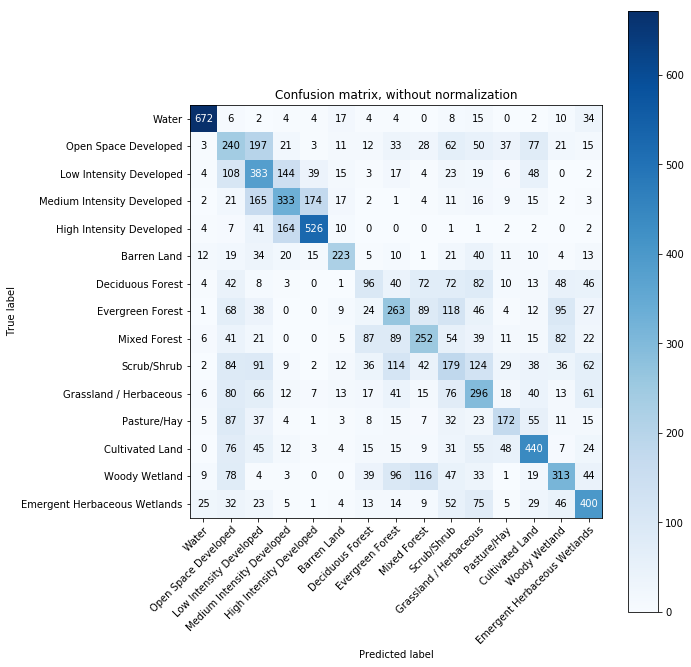

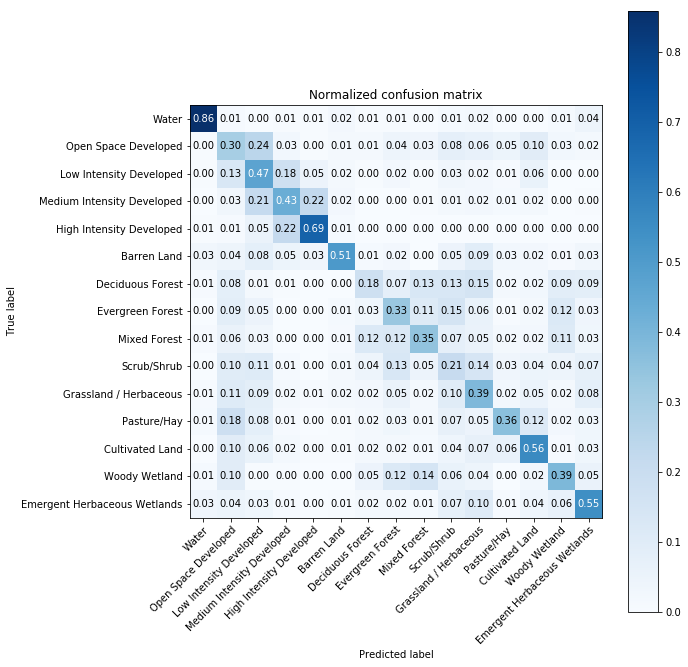

In [134]:
label_index = np.argmax(labels, axis=1)     
pred_index = np.argmax(predictions, axis=1)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
cu.plot_confusion_matrix(label_index, pred_index, classes=np.array(list(class_names)),
                      class_dict=class_names)

# Plot normalized confusion matrix
cu.plot_confusion_matrix(label_index, pred_index, classes=np.array(list(class_names)),
                      class_dict=class_names,
                      normalize=True)

In [135]:
count = 0
for i in range(len(label_index)):
    if(label_index[i] == pred_index[i]):
        count+=1
print("ACCURACY")
print(count/len(label_index))

ACCURACY
0.44129032258064516


In [136]:
print(label_index)

[ 2 10 12 ...  6 11 15]


In [137]:
label_index = np.argmax(labels, axis=1)     
pred_index = np.argmax(predictions, axis=1)

In [144]:
def merge_classes(y):
    # medium intensity and high intensity
    y[y == 2] = 4
    y[y == 3] = 4
    y[y == 5] = 4
    y[y == 7] = 8
    y[y == 9] = 8
    y[y == 14] = 8
    y[y==10] = 8
    return(y)

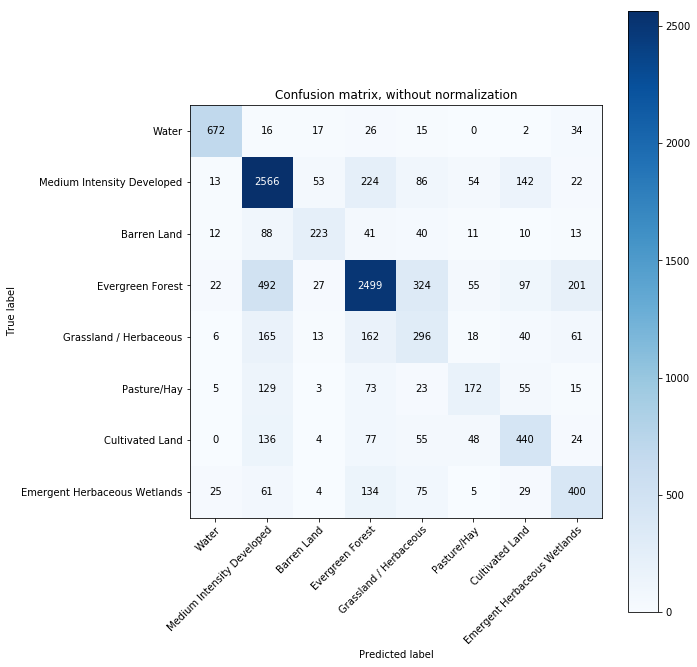

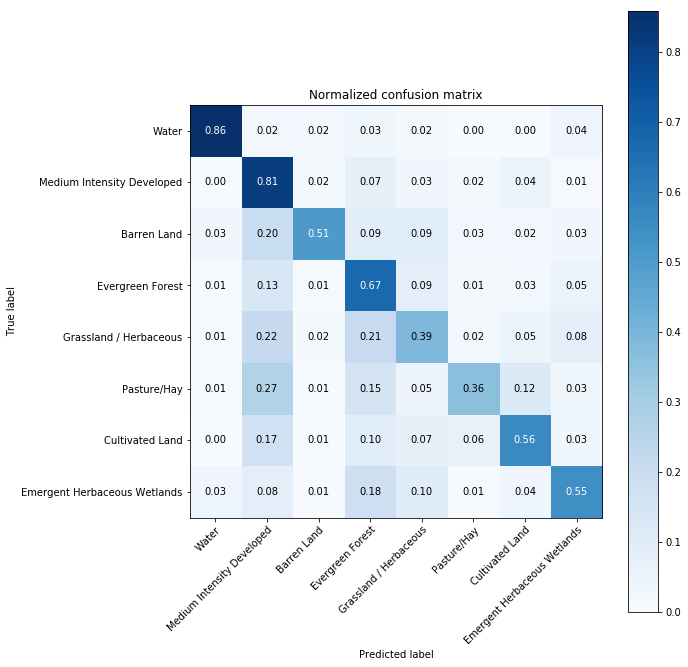

In [145]:
merge_classes(label_index)
merge_classes(pred_index)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
cu.plot_confusion_matrix(label_index, pred_index, classes=np.array(list(class_names)),
                      class_dict=class_names)

# Plot normalized confusion matrix
cu.plot_confusion_matrix(label_index, pred_index, classes=np.array(list(class_names)),
                      class_dict=class_names,
                      normalize=True)

In [146]:
count = 0
for i in range(len(label_index)):
    if(label_index[i] == pred_index[i]):
        count+=1
print("ACCURACY")
print(count/len(label_index))

ACCURACY
0.6698617511520737
